<a href="https://colab.research.google.com/github/janerikhy/BEM/blob/main/BEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

# Set directory paths for data files. 

# When using Google Colab: 
base_dir = os.path.abspath('')
drive_dir = os.path.join(base_dir, 'drive', 'MyDrive')
data_dir = os.path.join(drive_dir, 'BEM')

# When using local relative paths
"""
base_dir = os.path.dirname(__file__)
data_dir = os.path.join(BASE_DIR, 'data')
"""

profiles = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]

PROFILES = {}

BLADE = pd.read_csv(os.path.join(data_dir, 'bladedat.txt'),
                    sep="\t", header=None)
BLADE.columns = ['r', 'beta', 'c', 't/c']


for file in profiles:
  profile_type = file.split('/')[-1].split('.')[0]
  df = pd.read_csv(file, header=None)
  df.columns = ['alpha', 'Cl', 'Cd', 'Cm']
  PROFILES[int(profile_type)] = df

def foil_interp(t: float, a: float) -> tuple:
    """
    foil_interp takes the thickness and angle of attack
    to calculate the lift and drag coeffs. 

    Args:
        t (float): thickness of the foil section
        a (float): angle of attack in degrees
    Returns:
        tuple: (Cl, Cd)
    """
    if isinstance(a, list) or isinstance(a, np.ndarray):
      a = a[0]
    prof_t = [thick/10 for thick in PROFILES.keys()]
    # If we have complete data, we simply interpolate once
    if t in prof_t:
        t = int(t*10)
        Cl = np.interp(a, PROFILES[t]['alpha'], PROFILES[t]['Cl'])
        Cd = np.interp(a, PROFILES[t]['alpha'], PROFILES[t]['Cd'])
        return (Cl, Cd)

    # If thickness is not equal to a profile, double interpolation necessary
    prof_t = ([int(i*10) for i in prof_t])
    t = t*10
    prof_t.append(t)
    prof_t = sorted(prof_t)

    x_l = prof_t[prof_t.index(t) - 1]
    x_u = prof_t[prof_t.index(t) + 1]

    

    cl_1 = np.interp(a, PROFILES[x_l]['alpha'], PROFILES[x_l]['Cl'])
    cl_2 = np.interp(a, PROFILES[x_u]['alpha'], PROFILES[x_u]['Cl'])

    cd_1 = np.interp(a, PROFILES[x_l]['alpha'], PROFILES[x_l]['Cd'])
    cd_2 = np.interp(a, PROFILES[x_u]['alpha'], PROFILES[x_u]['Cd'])

    Cl = np.interp(t, [prof_t[prof_t.index(x_l)],
                   prof_t[prof_t.index(x_u)]], [cl_1, cl_2])
    Cd = np.interp(t, [prof_t[prof_t.index(x_l)],
                   prof_t[prof_t.index(x_u)]], [cd_1, cd_2])

    return (Cl, Cd)


In [140]:
# Set the constants
R = 89.17
B = 3
radius = [r for r in BLADE['r']]
rho = 1.225
V0 = 9.5
# speed_ratio = np.arange(5, 11, 1)
omega_min = 6*np.pi*2/60
omega_max = 9.7*2*np.pi/60

omega = np.arange(omega_min, omega_max, 0.01)
speed_ratio = np.array([o*R/V0 for o in omega])

min_pitch = -2
max_pitch = 6
pitch = np.arange(min_pitch, max_pitch, 0.1)


def bem(speed_ratio: np.ndarray, pitch: np.ndarray, V0: float):
  """
  The bem function takes a set of different tip speed ratios and pitch angls
  and calculates the loads over the wind turbine foils.

  Arguments:
    speed_ratio[array]: the array of different lambda values
    pitch[array]: array of pitch angles in degrees
    V0[float]: value of the incomming wind speed
  """
  P = np.zeros((len(speed_ratio), len(pitch)))
  T = np.zeros((len(speed_ratio), len(pitch)))
  Force_n = np.zeros((len(speed_ratio), len(pitch), len(radius)))
  Force_t = np.zeros((len(speed_ratio), len(pitch), len(radius)))

  # Factor for under relaxation
  beta = 0.1

  # Requirement for iteration loop
  eps = 5e-6
  for i in range(len(speed_ratio)):
    print(f"Percentage done: {i/len(speed_ratio)*100:.2f}%")
    omeg = speed_ratio[i]*V0/R
    for j in range(len(pitch)):
      pt = np.zeros((len(radius)))
      pn = np.zeros((len(radius)))

      for k in range(len(radius)):
        if radius[k]/R > 0.98:
            pt[k] = 0
            pn[k] = 0
            break
        counter = 0
        max_count = 1000
        a = 0
        ap = 0
        a_old = 0
        ap_old = 0
        diff_a = 1
        diff_ap = 1

        while (abs(diff_a) > eps) or (abs(diff_ap) > eps) and (counter < max_count):
          # Phi in radians
          phi = np.arctan2((1-a_old)*R, ((1+ap_old)*speed_ratio[i]*radius[k]))
          # Theta in degrees
          theta = BLADE['beta'][k] + pitch[j]

          # Alpha in degrees
          alpha = np.rad2deg(phi) - theta
          

          t = BLADE['t/c'][k]

          # Prandtl correction factor
          F = 2/np.pi * np.arccos(np.exp(-B/2*(R-radius[k])/(radius[k]*np.sin(abs(phi)))))
            
          # Interpolate to find Cl and Cd
          (Cl, Cd) = foil_interp(t, alpha)

          # Calculate normal and tangential load coeffs
          Cn = Cl*np.cos(phi) + Cd*np.sin(phi)
          Ct = Cl*np.sin(phi) - Cd*np.cos(phi)

          # Solidity for calculation
          sigma = BLADE['c'][k]*B/(2*np.pi*radius[k])

          # Thrust coeff
          C_T = (1-a_old)**2*Cn*sigma/(np.sin(phi)**2)

          if a_old < 1/3:
            # Update a without Glauert correction
            a = 1/(4*F*np.sin(phi)**2/(sigma*Cn) + 1)
          else:
            # Using Gluaert correction with under relaxation
            _a = C_T/(4*F*(1 - 1/4 * (5 - 3*a_old)*a_old))
            a = beta*_a + (1-beta)*a_old

          # Update a'
          ap = 1 / (4*np.sin(phi)*np.cos(phi)/(sigma*Ct) - 1)

          # Calculate difference to check for convergence
          diff_a = a - a_old
          diff_ap = ap - ap_old
          counter += 1
          a_old = a
          ap_old = ap

        # Calculate the relative wind speed
        U = (1-a)*V0
        U_t = (1 + ap)*omeg*radius[k]
        V_rel = np.sqrt(U**2 + U_t**2)

        Pt = 1/2*rho*V_rel**2*BLADE['c'][k]*Ct
        Pn = 1/2*rho*V_rel**2*BLADE['c'][k]*Cn

        pt[k] = Pt
        pn[k] = Pn
        # Change this, but we need the local normal forces to calculate moment
        Force_n[i][j][k] = Pn
        Force_t[i][j][k] = Pt
  

      # Here we can calculate the total loads for each ratio and pitch
      P[i][j] = omeg*B*np.trapz(radius*pt, radius)
      T[i][j] = B*np.trapz(pn, radius)
  print("Completed!")
  return (P, T, Force_n, Force_t)


P, T, FN, FT = bem(speed_ratio, pitch, V0)


CP = P/(1/2*rho*V0**3*np.pi*R**2)
CT = T/(1/2*rho*V0**2*np.pi*R**2)

X, Y = np.meshgrid(pitch, speed_ratio)



Percentage done: 0.00%
Percentage done: 2.56%
Percentage done: 5.13%
Percentage done: 7.69%
Percentage done: 10.26%
Percentage done: 12.82%
Percentage done: 15.38%
Percentage done: 17.95%
Percentage done: 20.51%
Percentage done: 23.08%
Percentage done: 25.64%
Percentage done: 28.21%
Percentage done: 30.77%
Percentage done: 33.33%
Percentage done: 35.90%
Percentage done: 38.46%
Percentage done: 41.03%
Percentage done: 43.59%
Percentage done: 46.15%
Percentage done: 48.72%
Percentage done: 51.28%
Percentage done: 53.85%
Percentage done: 56.41%
Percentage done: 58.97%
Percentage done: 61.54%
Percentage done: 64.10%
Percentage done: 66.67%
Percentage done: 69.23%
Percentage done: 71.79%
Percentage done: 74.36%
Percentage done: 76.92%
Percentage done: 79.49%
Percentage done: 82.05%
Percentage done: 84.62%
Percentage done: 87.18%
Percentage done: 89.74%
Percentage done: 92.31%
Percentage done: 94.87%
Percentage done: 97.44%
Completed!


## Question 1

Plot $C_P(\lambda, \theta_p)$ and find the optimal combination of tip speed ratio, $\lambda$, and pitch angle $\theta_p$. 

The contour plot is shown below and we can se that we achieve the highest $C_P$ with a tip speed ratio around 8 and pitch angle around 0.

From the report it is stated that the $C_P$ is found with a tip speed ratio $\lambda$ of 7.5.

To not have to use the BEM algorithm over and over again, we can save the results from the first run in a .csv file. Will therefore store the results in the following format:

$\lambda $ - $\theta_p$ - $C_P$ - $C_T$ 

And another table for the local normal loads

In [139]:
rho = 1.225
CP = P/(1/2*rho*V0**3*np.pi*R**2)
CT = T/(1/2*rho*V0**2*np.pi*R**2)

df_cp = pd.DataFrame(CP)
df_ct = pd.DataFrame(CT)
omega

array([0.62831853, 0.63831853, 0.64831853, 0.65831853, 0.66831853,
       0.67831853, 0.68831853, 0.69831853, 0.70831853, 0.71831853,
       0.72831853, 0.73831853, 0.74831853, 0.75831853, 0.76831853,
       0.77831853, 0.78831853, 0.79831853, 0.80831853, 0.81831853,
       0.82831853, 0.83831853, 0.84831853, 0.85831853, 0.86831853,
       0.87831853, 0.88831853, 0.89831853, 0.90831853, 0.91831853,
       0.92831853, 0.93831853, 0.94831853, 0.95831853, 0.96831853,
       0.97831853, 0.98831853, 0.99831853, 1.00831853])

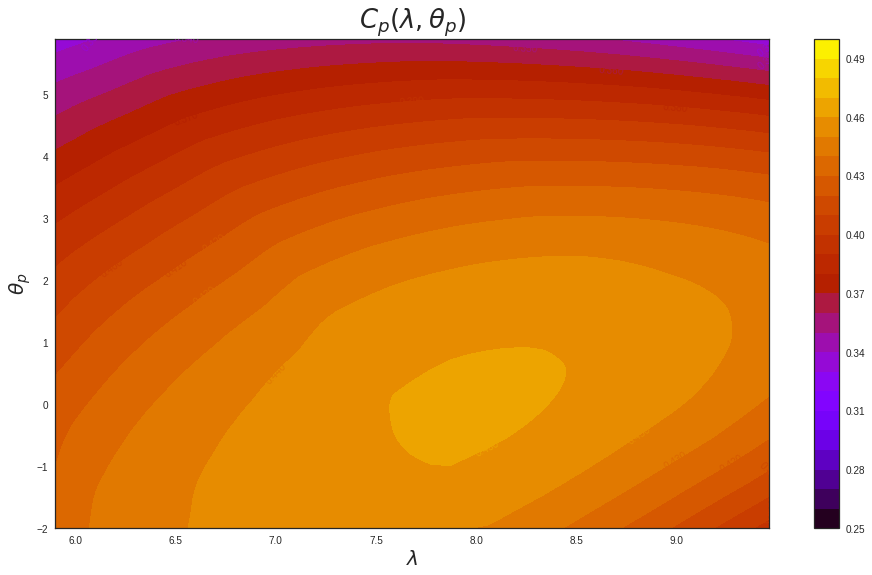

In [144]:
from datetime import datetime

now = datetime.now()

dt_string = now.strftime("%d%m%Y_%H:%M:%S")

plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(16, 9))
levels = np.arange(0.25, 0.510, 0.01)
CS = ax.contourf(Y, X, CP, levels, cmap="gnuplot")
fig.colorbar(CS)
ax.set_xlabel(r'$\lambda$', fontsize=20)
ax.set_ylabel(r"$\theta_p$", fontsize=20)
ax.set_title(r"$C_p(\lambda, \theta_p)$", fontsize=26)
ax.clabel(CS, inline=False, fontsize=10)
plt.savefig(os.path.join(data_dir, f'cp_contour_{dt_string}.png'), dpi=300)

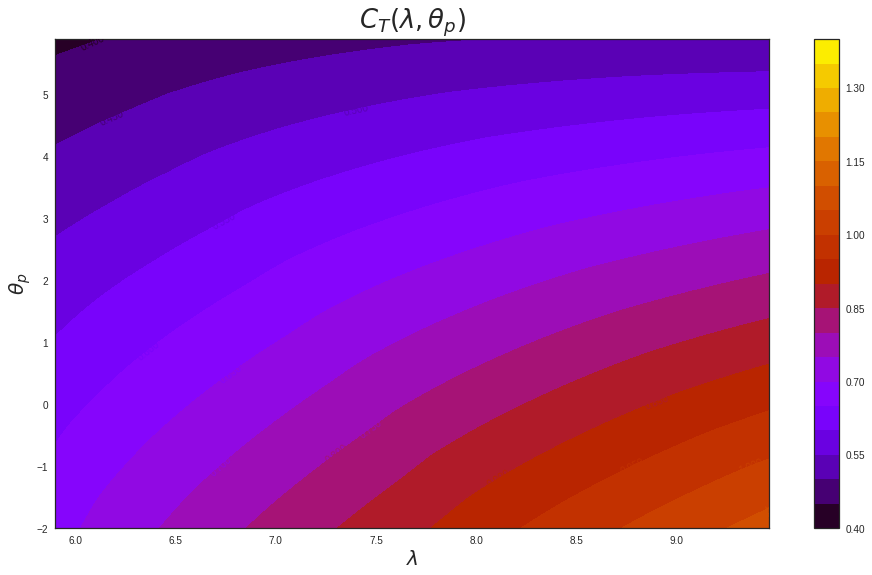

In [145]:
now = datetime.now()

dt_string = now.strftime("%d%m%Y_%H:%M:%S")

plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(16, 9))
levels = np.arange(0.4, 1.45, 0.05)
CS = ax.contourf(Y, X, CT, levels, cmap="gnuplot")
fig.colorbar(CS)
ax.set_xlabel(r'$\lambda$', fontsize=20)
ax.set_ylabel(r"$\theta_p$", fontsize=20)
ax.set_title(r"$C_T(\lambda, \theta_p)$", fontsize=26)
ax.clabel(CS, inline=False, fontsize=10)
plt.savefig(os.path.join(data_dir, f'ct_contour_{dt_string}.png'), dpi=300)

In [78]:
print(CT[-1])

[1.06936826 1.06328162 1.05719189 1.05108641 1.04484849 1.03860375
 1.03234946 1.02607799 1.01979247 1.01348088 1.00715136 1.00080918
 0.99445301 0.98807326 0.98167431 0.97525684 0.96881629 0.96235607
 0.95587221 0.94935391 0.94281413 0.93624173 0.92963399 0.92300144
 0.91634506 0.90966382 0.90295912 0.89623011 0.88950379 0.88279846
 0.8760449  0.86925569 0.86243261 0.85558055 0.84873772 0.84196547
 0.83516696 0.82832341 0.82143322 0.81448525 0.80749562 0.80054746
 0.79355822 0.78652076 0.77943458 0.77236523 0.76526924 0.75816304
 0.75103562 0.74383175 0.73656993 0.72922833 0.72182548 0.71438477
 0.70688883 0.69933732 0.691731   0.68407726 0.67637304 0.66861876
 0.66080534 0.65294714 0.6450438  0.63709989 0.62911898 0.62108679
 0.61301613 0.60490509 0.59675394 0.5885663  0.58033252 0.57205919
 0.56375091 0.55541075 0.54703392 0.53861886 0.53016837 0.52168482
 0.51316652 0.50461061]


**Testing of the interpolation function**

To make sure that the function for double interpolation works, this section will perfom an interpolation in stages and check how the functions corresponds to this result. 


In [146]:
# Want to test the interpolation 

t1 = BLADE['t/c'][1] # Checking with a thickness - cord length ratio of 86.049 (at the second radius)

# Setting arbitrary angle of attack to 4 deg
alpha = 4

# Find the lift coefficient for the closest foils (1000 & 600)
cl_1000 = np.interp(alpha, PROFILES[1000]['alpha'], PROFILES[1000]['Cl'])

cl_600 = np.interp(alpha, PROFILES[600]['alpha'], PROFILES[600]['Cl'])


# Try interpolating between the two of them
cl_860 = np.interp(t1, [60, 100], [cl_600, cl_1000])
cl_860

cl_from_func = foil_interp(t1, alpha)

# Result from the two processes: 
print("Difference between manual double interpolation and function: {:.17f}".format(cl_860-cl_from_func[0]))

Difference between manual double interpolation and function: 0.00000000000000006


**Question 2**

Tip speed limited to $90$ $[\frac{m}{s}]$.

$\omega_{max}$ = 1.01 $[\frac{rad}{s}]$, which is the same as $\approx$ 9.6 $RPM$ that was set at maximum rotational speed in the report. 

What would be the maximum wind where the turbine can run   at its maximum efficiency $C_{P,opt}(λ_{opt},θ_{p, opt})$ and what would be the power.  Plot ω(Vo). 

\begin{equation}
\lambda = \frac{\omega R}{V_0}
\end{equation}

We could probably iterate over the different speed ratios to find the combination of speed ratio and pitch angle that gives the largest $C_P$ in general. 

\begin{equation}
P = T\omega
\end{equation}

*Keep in mind that the cut of wind speed in the report is said to be 25 $[\frac{m}{s}]$. And rated wind speed is found as 11.4 $[\frac{m}{s}]$*




To find the optimal $\lambda$ and $\theta_p$ we extract the maximum value of $C_P$ and the corresponding values of $\lambda$ and $\theta_p$.

In [147]:
lam_opt, theta_opt = 0, 0
lam_index, theta_index = None, None
max_cp = 0

for i in range(len(speed_ratio)):
  max_val = max(CP[i])
  if max_val > max_cp:
    max_cp = max_val
    lam_index = i
    theta_index = np.argmax(CP[i])
    theta_opt = pitch[theta_index]
    lam_opt = speed_ratio[i]

print(f"Optimal pitch = {theta_opt:.3f} [rad/s]")
print(f"Optimal tip speed ratio: {lam_opt:.2f}")
print(f"Max Cp: {max_cp:.4f}")

Optimal pitch = -0.100 [rad/s]
Optimal tip speed ratio: 7.96
Max Cp: 0.4617


From the calculations we find that:



*   $\lambda_{opt}$ = 7.96 $\approx$ 8 
*   $\theta_{p, opt}$ = -0.099 $\approx$ -0.1

## Ask if this is reasonable values and why the differ from that in the report.



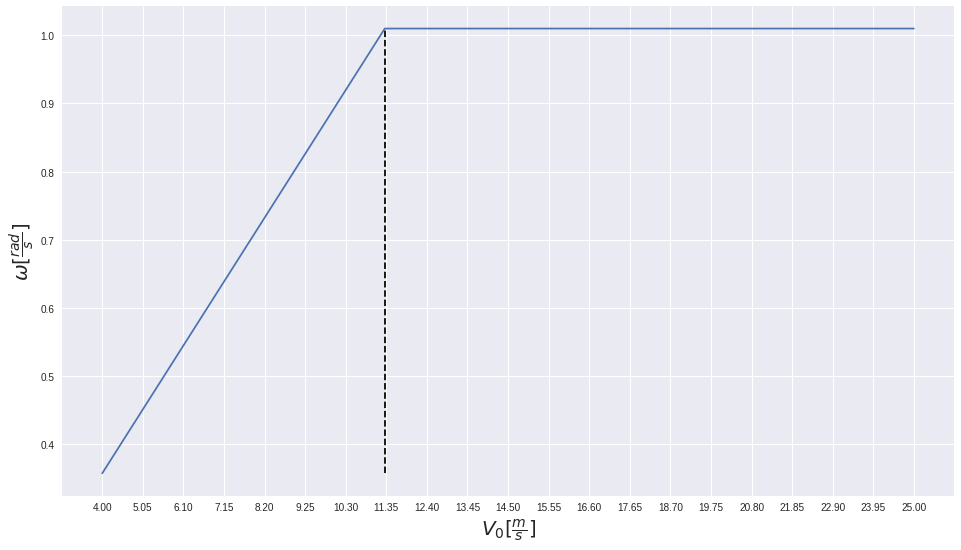

In [148]:
# We want to plot V_0 (incomming wind speed) as a function of the rotational speed where it can maintan top power output
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 9)

def w(V: float) -> float:
  """
  Calculate the necessary wind speed to have Cp_opt

  Constants:
    lambda = 7.96
    ptich angle = -0.1
    w_max = 1.01

  Vairables:
    w[float]: The rotational speed
  """
  w_max = 1.01
  l = 7.96
  w = lam_opt*V/R

  if w > w_max:
    return w_max
  return w

v = np.arange(4, 25.01, 0.01)

rot_speed = np.arange(0.01, 1.02, 0.01)

w_arr = np.asarray([w(V) for V in v])

plt.plot(v, w_arr)
plt.vlines(v[np.argmax(w_arr)], min(w_arr), w_arr[np.argmax(w_arr)], linestyles='dashed')
plt.xticks(v[::len(v)//20])
plt.xlabel(r"$V_0 [\frac{m}{s}]$", fontsize=20)
plt.ylabel(r"$\omega [\frac{rad}{s}]$", fontsize=20)
plt.savefig(os.path.join(data_dir, 'results', 'omega_vs_v0.png'), dpi=300)
plt.show()

In [149]:
V_max = v[np.argmax(w_arr)]
print(f"V_0 max: {V_max:.4f}")

V_0 max: 11.3200


In [150]:
# At wind of v_max we would be able to extract:

P_max = CP[lam_index][theta_index]*1/2 * rho * V_max**3*np.pi*R**2  # [W]
print(f"{P_max*1e-6:.2f} [MW]")

10.25 [MW]


In [168]:
# Start with fixing the frequency to w_max
# omega = np.asarray([1.01])
#P_max = 10*1e6
w_max = 1.01

# Want to find theta_p as a function of V0 to limit the power to 10MW

V0_arr = np.arange(4, 26, 1)  # Incomming wind speed array
pitch_angles = np.arange(0, 25, 0.01)
#pitch_angles = np.arange(-25, 1, 0.01)
pitch_req = np.zeros(len(V0_arr))
Power = np.zeros(len(V0_arr))
Thrust = np.zeros(len(V0_arr))
C_power = np.zeros(len(V0_arr))
C_thrust = np.zeros(len(V0_arr))
norm_forces = np.zeros((len(V0_arr), len(radius)))
tan_forces = np.zeros((len(V0_arr), len(radius)))


for i in range(len(V0_arr)):
  if V0_arr[i] < 11.4:
    Power[i] = CP[lam_index][theta_index]*1/2 * rho * V0_arr[i]**3 * np.pi*R**2
    Thrust[i] = CT[lam_index][theta_index]*1/2 * rho * V0_arr[i]**2 * np.pi*R**2
    C_power[i] = CP[lam_index][theta_index]
    C_thrust[i] = CT[lam_index][theta_index]
    _, _, f, ft = bem(np.asarray([lam_opt]), np.asarray([theta_opt]), V0_arr[i])
    for k in range(len(radius)):
      norm_forces[i][k] = f[0][0][k]
      tan_forces[i][k] = ft[0][0][k] 
  else:
    l = w_max*R/V0_arr[i]
    p, t, f, ft = bem(np.asarray([l]), pitch_angles, V0_arr[i])
    for j in range(len(p[0])):
      if (p[0][j] < P_max):
        # Make interpolation to find the correct pitch angle
        pitch_req[i] = np.interp(P_max, p[0][j-1:j+1], pitch_angles[j-1:j+1])
        Power[i] = np.interp(pitch_req[i], pitch_angles[j-1:j+1], p[0][j-1:j+1])
        Thrust[i] = np.interp(pitch_req[i], pitch_angles[j-1:j+1], t[0][j-1:j+1])
        C_power[i] = Power[i]/(1/2 * rho * V0_arr[i]**3 * np.pi*R**2)
        C_thrust[i] = Thrust[i]/(1/2 * rho * V0_arr[i]**2 * np.pi*R**2)
        for k in range(len(radius)):
          norm_forces[i][k] = f[0][j][k]
          tan_forces[i][k] = ft[0][j][k]
        break

pitch_req



Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!
Percentage done: 0.00%
Completed!


array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  4.93,
        7.45,  9.36, 10.98, 12.44, 13.8 , 15.07, 16.28, 17.43, 18.54,
       19.62, 20.67, 21.68, 22.66])

In [120]:
p[0]

array([-19973668.69342257, -17068130.02075237, -14511268.30113953,
       -12066018.64757189,  -9707246.89086298,  -7492943.74116527,
        -5476601.00908788,  -3426844.54891137,  -1420678.63000788,
          459950.46651261,   2090434.95632058,   3524113.91476627,
         4887882.23263592,   6160585.85895618,   7299101.94464271,
         8172355.83401362,   8859994.69603532,   9501904.05817807,
        10081644.63428746,  10616983.08389673,  11091499.84551546,
        11485314.78707996,  11794500.355886  ,  12002197.04002617,
        12109601.65036598,  12134460.07084873])

### Question 3

Want to plot the following:

* $C_P(V_0)$
* $C_T(V_0)$
* $P(V_0)$
* $T(V_0)$
* $\theta_p(V_0)$

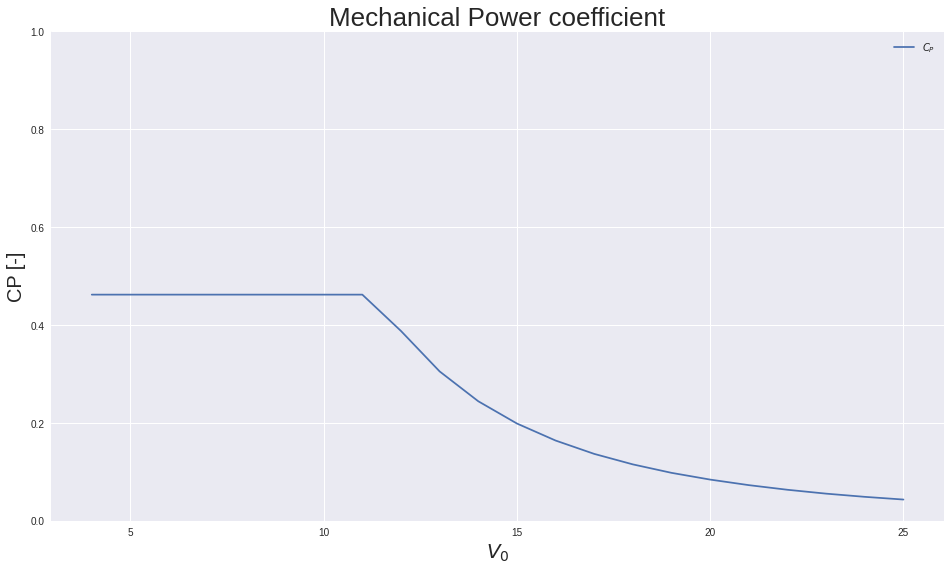

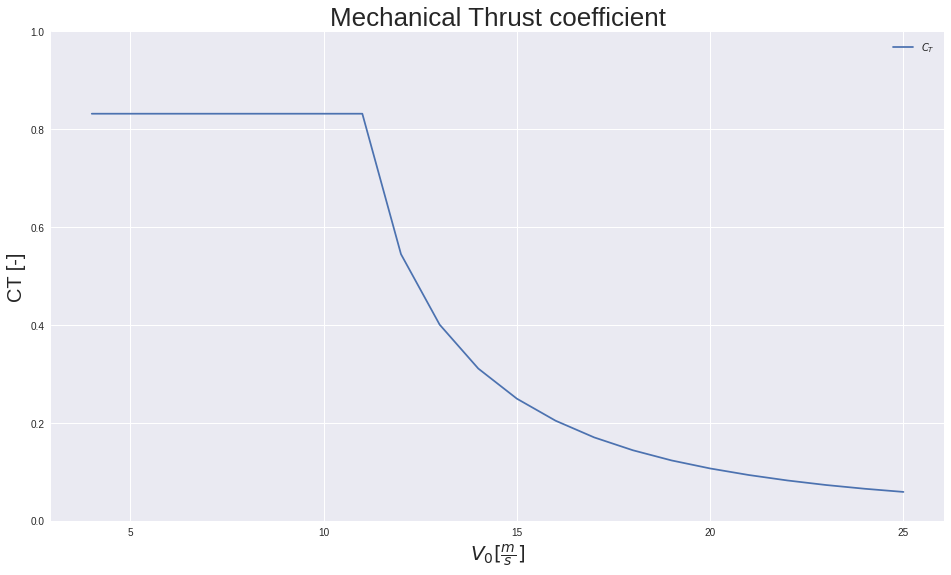

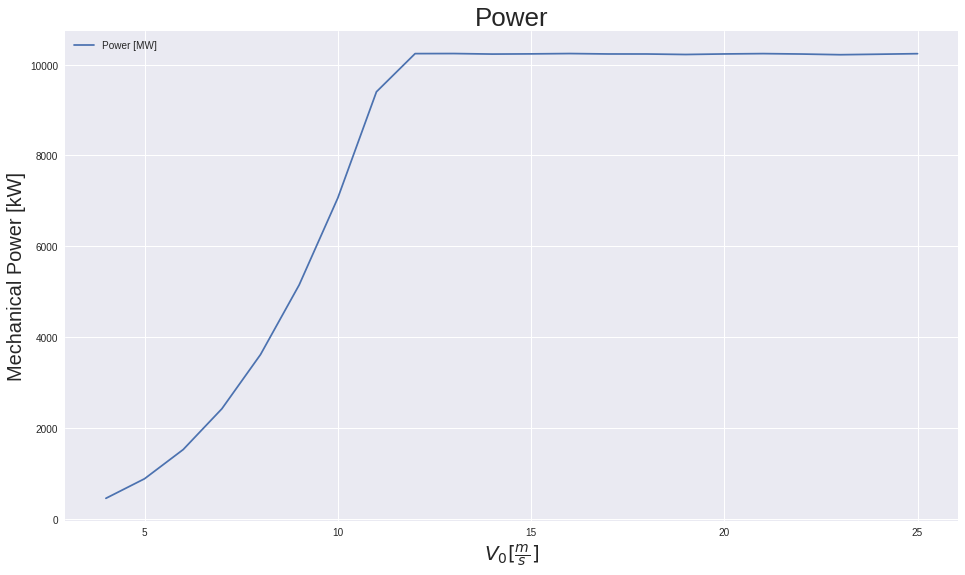

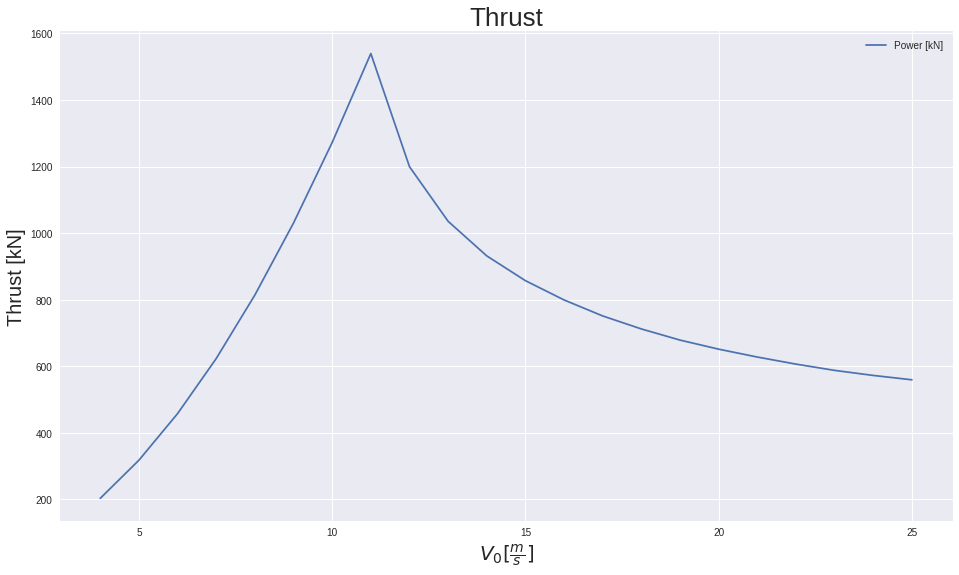

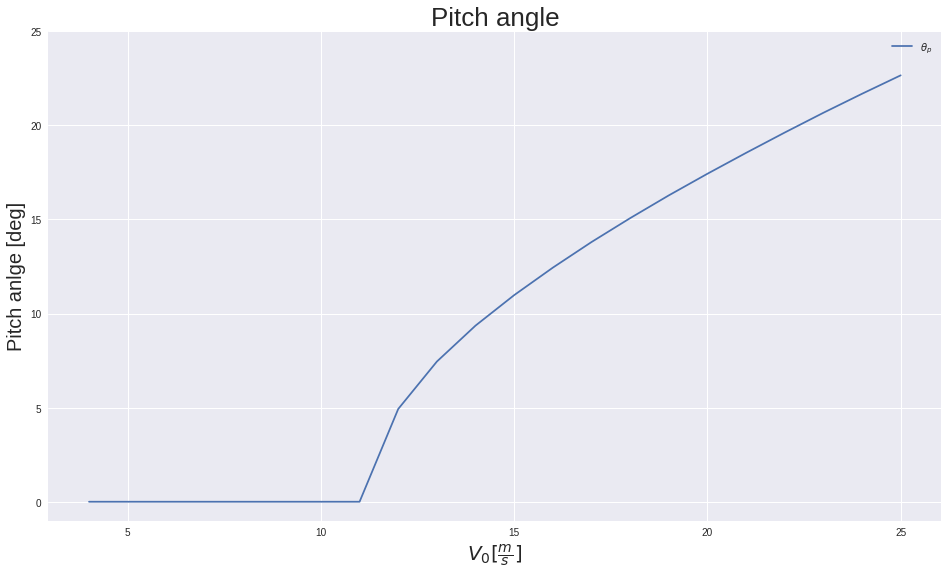

In [153]:
# Plots for question 3
#plt.rcParams.keys()
plt.style.use('seaborn')
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (16, 9)

# CP(V0) and CT(V0)

''' plt.plot(V0_arr, C_power, label=r"$C_P$")
plt.plot(V0_arr, C_thrust, label=r"$C_T$")
plt.title(r"$C_P(V_0)$ and $C_T(V_0)$", fontsize=26)
plt.xlabel(r"$V_0$", fontsize=20)
plt.legend()
plt.savefig(os.path.join(data_dir, 'results', 'cp_and_ct_negative_pitch.png'), dpi=300)
plt.show()
 '''

# CP (V0)
plt.plot(V0_arr, C_power, label=r"$C_P$")
plt.title(r"Mechanical Power coefficient", fontsize=26)
plt.xlabel(r"$V_0$", fontsize=20)
plt.ylim([0, 1])
plt.ylabel("CP [-]", fontsize=20)
plt.legend()
plt.savefig(os.path.join(data_dir, 'results', 'cp.png'), dpi=300)
plt.show()

# CT (V0)
plt.plot(V0_arr, C_thrust, label=r"$C_T$")
plt.title(r"Mechanical Thrust coefficient", fontsize=26)
plt.xlabel(r"$V_0 [\frac{m}{s}]$", fontsize=20)
plt.ylabel("CT [-]", fontsize=20)
plt.ylim([0, 1])
plt.legend()
plt.savefig(os.path.join(data_dir, 'results', 'ct.png'), dpi=300)
plt.show()

# Power
plt.plot(V0_arr, Power*1e-3, label="Power [MW]")
plt.title("Power", fontsize=26)
plt.xlabel(r"$V_0 [\frac{m}{s}]$", fontsize=20)
plt.ylabel(r"Mechanical Power [kW]", fontsize=20)
plt.legend()
plt.savefig(os.path.join(data_dir, 'results', 'power.png'), dpi=300)
plt.show()

# Thrust
plt.plot(V0_arr, Thrust*1e-3, label="Power [kN]")
plt.title("Thrust", fontsize=26)
plt.xlabel(r"$V_0 [\frac{m}{s}]$", fontsize=20)
plt.ylabel(r"Thrust [kN]", fontsize=20)
plt.legend()
plt.savefig(os.path.join(data_dir, 'results', 'thrust.png'), dpi=300)
plt.show()

# Pitch angle
plt.plot(V0_arr, pitch_req, label=r"$\theta_p$")
plt.title("Pitch angle", fontsize=26)
plt.xlabel(r"$V_0 [\frac{m}{s}]$", fontsize=20)
plt.ylabel(r"Pitch anlge [deg]", fontsize=20)
plt.ylim([-1, 25])
plt.legend()
plt.savefig(os.path.join(data_dir, 'results', 'pitch_angle.png'), dpi=300)
plt.show()

## NOTE: 
There are some deviation in the thrust coefficient plot when comparing it to that in the report. 

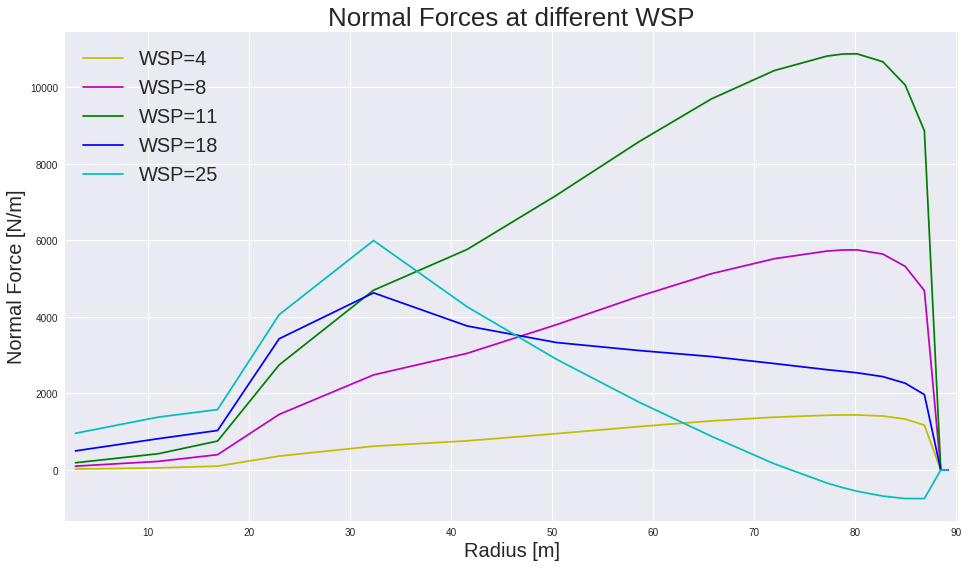

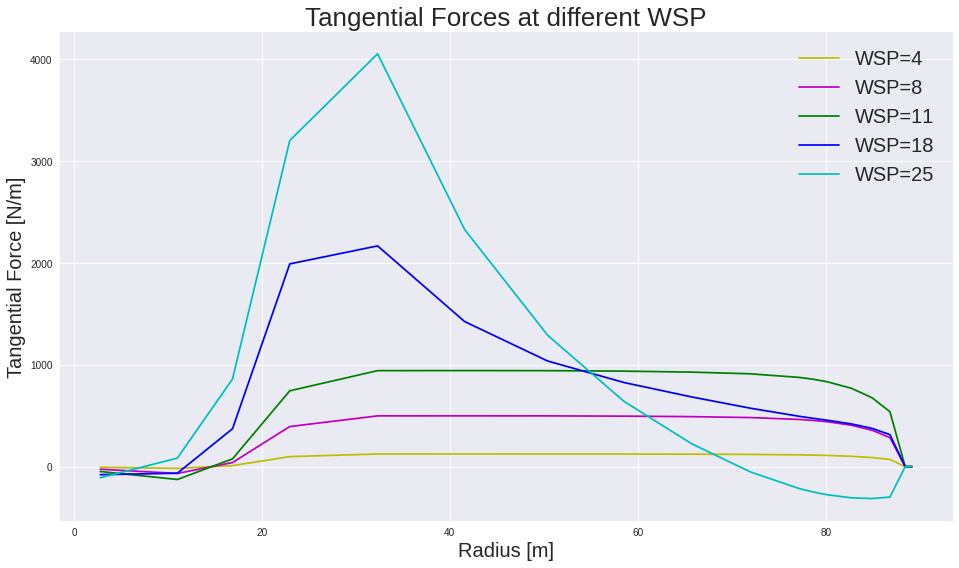

In [179]:
v_moments = [4, 8, 11, 18, 25]
colors = ['y', 'm', 'g', 'b', 'c']

for i in range(len(v_moments)):
  val = np.where(V0_arr == v_moments[i])[0][0]
  plt.title("Normal Forces at different WSP", fontsize=26)
  plt.plot(radius, norm_forces[val], colors[i] ,label=f"WSP={v_moments[i]}")
  plt.xlabel("Radius [m]", fontsize=20)
  plt.xlim([min(radius)-1, max(radius)+1])
  plt.ylabel("Normal Force [N/m]", fontsize=20)
  plt.legend(fontsize=20)
  plt.savefig(os.path.join(data_dir, 'results', 'normal_forces_radi.png'), dpi=300)

plt.show()

plt.close()
for i in range(len(v_moments)):
  val = np.where(V0_arr == v_moments[i])[0][0]
  plt.title("Tangential Forces at different WSP", fontsize=26)
  plt.plot(radius, tan_forces[val], colors[i], label=f"WSP={v_moments[i]}")
  plt.xlabel("Radius [m]", fontsize=20)
  plt.ylabel("Tangential Force [N/m]", fontsize=20)
  plt.legend(fontsize=20)
  plt.savefig(os.path.join(data_dir, 'results', 'tan_forces_radi.png'), dpi=300)

plt.show()

In [175]:
# Calculate the moments 

# Have to integrate from the radius of r=2.8 m for wind speeds [4, 8, 11, 25]

moments = np.zeros((len(v_moments)))
moments_t = np.zeros((len(v_moments)))
for i in range(len(moments)):
  val = np.where(V0_arr == v_moments[i])[0][0]
  moments[i] = np.trapz(radius*norm_forces[val], radius)
  moments_t[i] = np.trapz(radius*tan_forces[val], radius)


print(f"Moment from normal forces\n")
print(f"-"*50)
print(f"Wind speed [m/s]\t Moment [kNm]")
print(f"-"*50)
for i in range(len(moments)):
  print(f"{v_moments[i]}\t\t | {moments[i]*1e-3:.2f}")
  print("-"*50)

print(f"\n\n\nMoment from tangential forces\n")
print(f"-"*50)
print(f"Wind speed [m/s]\t Moment [kNm]")
print(f"-"*50)
for i in range(len(moments)):
  print(f"{v_moments[i]}\t\t | {moments_t[i]*1e-3:.2f}")
  print("-"*50) 



Moment from normal forces

--------------------------------------------------
Wind speed [m/s]	 Moment [kNm]
--------------------------------------------------
4		 | 4064.21
--------------------------------------------------
8		 | 16256.83
--------------------------------------------------
11		 | 30735.58
--------------------------------------------------
18		 | 11444.22
--------------------------------------------------
25		 | 6287.79
--------------------------------------------------



Moment from tangential forces

--------------------------------------------------
Wind speed [m/s]	 Moment [kNm]
--------------------------------------------------
4		 | 421.89
--------------------------------------------------
8		 | 1687.55
--------------------------------------------------
11		 | 3190.53
--------------------------------------------------
18		 | 3377.49
--------------------------------------------------
25		 | 3379.84
--------------------------------------------------


AEO: 37476025.908171415
AEO loss: 854093.988290505
Percentage loss: 2.28%
Capacity factor:= 42.78%


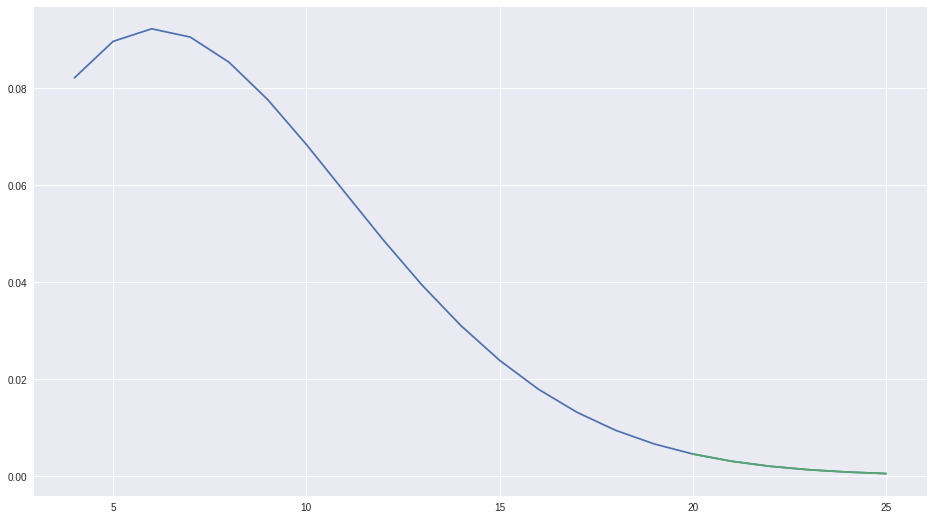

In [158]:
# Task 5


def h(v, k, A):
  return k/A * (v/A)**(k-1) * np.exp(-(v/A)**k)

def H(v, k, A):
  return np.exp(-(v/A)**k)

k = 1.9
A = 9

aeo = 0
aeo_loss = 0
vv = np.arange(4, 26, 1)

for i in range(len(V0_arr) -1):
  aeo += 1/2 * (Power[i] + Power[i+1]) * 8760 * (H(V0_arr[i], k, A) - H(V0_arr[i+1], k, A))

for i in range(np.where(V0_arr == 20)[0][0], len(V0_arr)-1):
  aeo_loss += 1/2 * (Power[i] + Power[i+1]) * 8760 * (H(V0_arr[i], k, A) - H(V0_arr[i+1], k, A))

print(f"AEO: {aeo*1e-3}")
print(f"AEO loss: {aeo_loss*1e-3}")
print(f"Percentage loss: {aeo_loss/aeo*100:.2f}%")

plt.plot(V0_arr, h(V0_arr, 1.9, 9))
plt.plot(V0_arr[np.where(V0_arr == 20)[0][0]:], h(V0_arr[np.where(V0_arr == 20)[0][0]:], k, A))

print(f'Capacity factor:= {aeo/(10*1e6*8760)*100:.2f}%')


# Question 5 results:




In [87]:
Power

array([ 463149.90649283,  904589.66111882, 1563130.93441332,
       2482194.03011004, 3705199.25194268, 5275566.90364495,
       7236717.28895054, 9632070.71159317, 9991996.95011997,
       9999568.57853592, 9996703.08695265, 9997210.57289354,
       9992322.5660085 , 9994794.38132271, 9993450.99151594,
       9988347.03563955, 9982383.26747324, 9971577.44479079,
       9975843.97043938, 9978192.95587505, 9982833.92513455,
       9980432.95905284])